
# Quickstart :ベーシックな合成シミュレーションとデータセット(連続空間)

このノートブックではベーシックな合成データセットでのオフ方策学習(OPE)とオフライン強化学習(Offline RL)の実行例を紹介します。

ベーシックなシミュレーションとデータセットの例は5つのステップから成り立っています。

0. (ベーシックな合成シミュレーション環境の設定とオンライン強化学習)
1. 合成データの生成
2. オフライン強化学習
3. オフ方策評価とオフライン強化学習手法の評価
4. オフ方策評価手法の評価

\* このライブラリは、オンラインとオフラインの方策・モデルベース評価で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています.   
\*また[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考に実装しています.

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead, TruncatedGaussianHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# 警告の無視
import warnings
warnings.simplefilter('ignore')


## 0. (ベーシックな合成シミュレーション環境の設定とオンライン強化学習)
まず初めにベーシックな環境を紹介します.

#### 強化学習でのベーシック環境のセットアップ
ベーシックな合成シミュレーションにおいて, 強化学習エージェントの目的は累積報酬を最大化することです.

この問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します.
- `状態`: POMDPによってノイズが加わった状態観測.
- `行動`: 強化学習エージェントにより選択された行動.
- `報酬`: 報酬観測.

より詳細に環境の引数を確認したい場合は、次のノートブックを参照してください.[examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).


In [9]:
# 環境のセットアップ
env = BasicEnv(random_state=random_state)

In [10]:
# ランダムエージェントを定義
agent = OnlineHead(
    ContinuousRandomPolicyConfig().create(device=device),
    name="random",
)
agent.build_with_env(env)

In [11]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述可能
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [12]:
# 状態
print(obs)
print(obs.shape)

[-0.37164978 -0.49943402  0.36963097 -0.28399277 -0.62862005]
(5,)


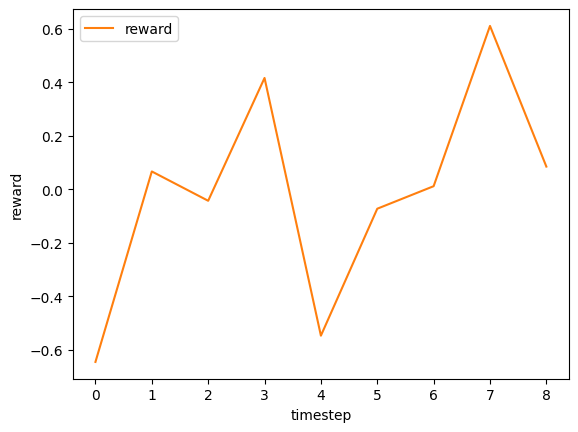

In [13]:
# ランダムエージェントでの報酬の推移を可視化します
obs, info = env.reset()
done = False
reward_list = []

while not done:
    action = agent.sample_action_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

# プロット
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')
plt.show()

#### オンライン強化学習と方策の比較
オンラインの方策価値の推定に基づいて, オフライン強化学習で学習した方策とランダム方策を比較します.

In [ ]:
# 連続行動空間に対する標準的な環境
env = gym.make("BasicEnv-continuous-v0")
print(env.action_space)

Box(-1.0, 1.0, (3,), float64)


In [15]:
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# モデル
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    ),
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [18]:
# モデルの保存
sac.save_model("d3rlpy_logs/sac.pt")

In [16]:
# モデルのリロード
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

Text(0, 0.5, 'episode reward')

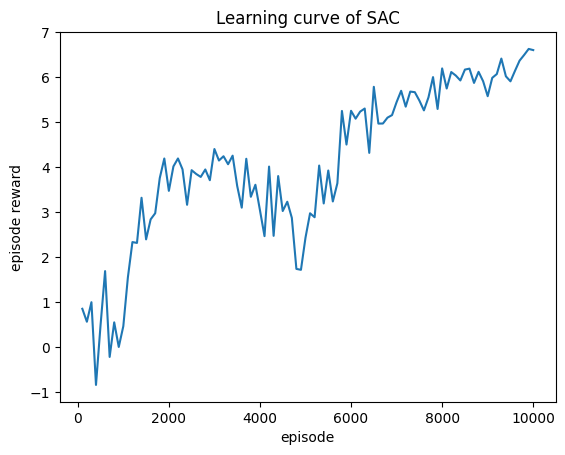

In [17]:
# モデルの学習曲線
log_path = sorted(glob("d3rlpy_logs/SAC_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of SAC")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [18]:

random = ContinuousRandomPolicyConfig().create(device=device)
random.build_with_env(env)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

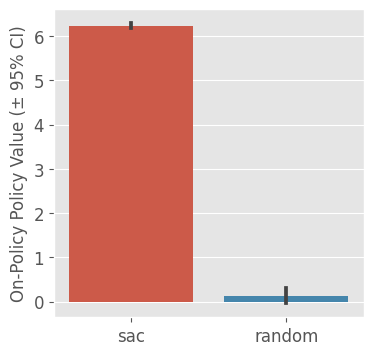

In [19]:
# オンラインでの性能比較
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, random],
    policy_names=["sac", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [20]:
# sac方策のオンライン評価による方策価値
# ランダム方策より大幅に改善しています
sac_performance = calc_on_policy_policy_value(env, sac, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("improvement:", sac_performance - random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

improvement: 6.220823797617203


<!-- Note that, we provide the following functions for online evaluation of the policy performance under `scope_rl.ope.online`. -->
`scope_rl.ope.online`において以下の関数で, 方策の性能をオンライン評価できます.

(統計量)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(可視化)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. 合成データの生成
前のセクションでは合成シミュレーションを利用して, どのようにオンライン環境との相互作用するかを見てきました. シミュレーションでは簡単にエージェントを学習することができますが, 実環境でオンラインの相互作用を行うことはリスクを伴います. そこでオフライン強化学習では挙動方策$\pi_0$から集められたオフラインのログデータのみを利用することで新しい方策を学習することを考えます.

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は$t$で観測された状態, $a_t$ は挙動方策 $\pi_0$によって選択された行動, $r_t$は報酬を表します.

合成データを簡単に生成するデータセットモジュールクラスとして `SyntheticDataset`を実装しています

シミュレーション環境を仮想の実環境とみなすことで, ログデータを利用したオフ方策強化学習の方法を紹介します.

`SyntheticDataset` は以下の引数を持っています:
- `env`: 前のセクションで紹介したベーシックな合成環境を定義.
- `max_episode_steps`: 一つのエピソードにおける最大の時刻.

In [21]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)

In [22]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# ログデータがある存在する場合はスキップ
# 挙動方策によってログデータを集める
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [24]:
train_logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 3,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.10666174, -0.43413801,  0.69911049, -0.49153976,  0.26416026],
        [-0.09165767,  0.53838334,  0.57967616,  0.25195753,  0.54975922],
        ...,
        [-0.58171771,  0.6782399 ,  0.07907731,  0.44068758,  0.03371026],
        [-0.03506825, -0.34642982,  0.70207422, -0.36781008,  0.50056381],
        [ 0.09089026,  0.70256162,  0.47892005,  0.20888019,  0.47450056]]),
 'action': array([[ 0.63094648, -0.93446503,  0.56403605],
        [ 0.48463834,  0.22951301, -0.71212477],
        [ 0.90848962, -0.58848582, -0.62280191],
        ...,
        [ 0.633153  , -0.9542258 , -0.43497972],
        [ 0.42549025,  0.32503334, -0.6607296 ],
        [ 0.80997434, -0.30832653,

In [25]:
with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [26]:
with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

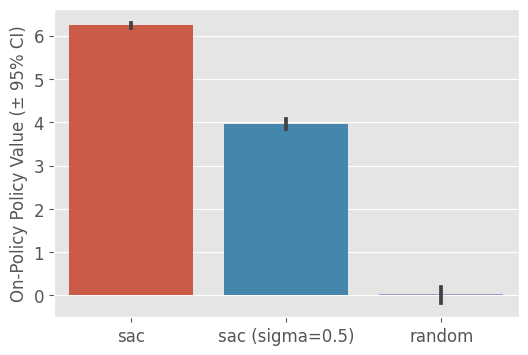

In [27]:
# オンラインでの方策性能の比較
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, random],
    policy_names=["sac", "sac (sigma=0.5)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

より詳細にデータ収集と可視化について知りたい場合は,  [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection.ipynb)を参照してください.
<!-- For more about the data collection and visualization, please refer to [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection.ipynb). -->

## 2. オフライン強化学習
このセクションでは環境と相互作用せずに新しい方策を学習する方法を紹介します.
オフライン教科学習のアルゴリズムは [d3rlpy](https://github.com/takuseno/d3rlpy)を利用しています.
<!-- ## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting with the environment.
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of offline RL algorithms. -->

In [30]:
# d3rlpyのモジュールのインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQLConfig

In [29]:
offlinerl_dataset = MDPDataset(
    observations=test_logged_dataset["state"],
    actions=test_logged_dataset["action"],
    rewards=test_logged_dataset["reward"],
    terminals=test_logged_dataset["done"],
)

In [31]:
# Use Conservative Q-Learning policy
# Conservative Q-Learning 方策を利用
cql = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
cql.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [33]:
# モデルの保存
cql.save_model("d3rlpy_logs/cql_continuous.pt")

In [34]:
# モデルのリロード
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_continuous.pt")

2023-07-22 16:29:44 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

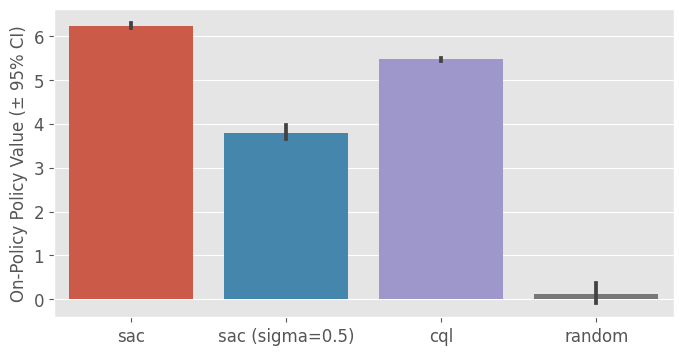

In [36]:
# オンラインでの方策性能の比較
# オンラインでの相互作用せずに, オフラインアルゴリズムはオンラインと同等程度の性能を持っています.
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, cql, random],
    policy_names=["sac", "sac (sigma=0.5)", "cql", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. オフ方策評価とオフライン強化学習手法の評価
前のセクションではオンラインの相互作用(A/Bテスト)により学習した方策の性能を確認しました.しかし, 実務では方策の性能が悪い可能性があるため, オンライン実験はリスクを伴います. ここでエージェントが環境でどのように動作するかを前もって知るために, オンラインではなくオフラインでの方策性能の評価を行います.

#### 推定ターゲット
推定量の平均的な方策の性能, つまり*方策価値*を推定することが目的になります.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [37]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.continuous import DirectMethod as DM
from scope_rl.ope.continuous import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.continuous import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.continuous import DoublyRobust as DR
from scope_rl.ope.continuous import SelfNormalizedTIS as SNTIS
from scope_rl.ope.continuous import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.continuous import SelfNormalizedDR as SNDR
from scope_rl.policy import ContinuousEvalHead

In [38]:
# 評価方策を定義
cql_ = ContinuousEvalHead(
    base_policy=cql,
    name="cql",
)
sac_ = ContinuousEvalHead(
    base_policy=sac, 
    name="sac", 
)
evaluation_policies = [cql_, sac_]

In [39]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        },
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    ),
)

In [ ]:
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [41]:
with open("logs/ope_input_dict_continuous.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [42]:
with open("logs/ope_input_dict_continuous.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [43]:
input_dict

{'cql': {'evaluation_policy_action_dist': None,
  'evaluation_policy_action': array([[ 0.7895372 , -0.79363215, -0.52138674],
         [ 0.8106339 , -0.33552885, -0.45466143],
         [ 0.78984964, -0.4607501 ,  0.70200634],
         ...,
         [ 0.78719187,  0.18121517, -0.56885785],
         [ 0.78742146,  0.06306946, -0.48978412],
         [ 0.76593447, -0.43075836,  0.6505569 ]], dtype=float32),
  'state_action_value_prediction': array([[4.30566072, 4.58573961],
         [4.97807884, 4.73458385],
         [4.75874472, 4.98025274],
         ...,
         [4.28577471, 4.6361475 ],
         [4.45088673, 4.58396673],
         [4.59209585, 4.74256086]]),
  'initial_state_value_prediction': array([4.58573961, 4.65792894, 4.77657366, ..., 4.72337389, 4.84374475,
         4.34953928]),
  'state_action_marginal_importance_weight': None,
  'state_marginal_importance_weight': None,
  'on_policy_policy_value': array([5.74958172, 5.31987359, 5.48685406, 5.67917462, 5.116804  ,
         5.67

In [44]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high,  
    ),
    bandwidth=5.0,
)

In [45]:
# opeによる性能評価
# 計算に時間がかかります(約15分)
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [46]:
# 推定された方策性能
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy  5.466111e+00           1.000000e+00
 dm         4.717382e+00           8.630235e-01
 tis        1.348137e+20           2.466355e+19
 pdis      -2.820616e+20          -5.160188e+19
 dr        -1.780842e+20          -3.257968e+19
 sntis      1.322637e+00           2.419705e-01
 snpdis    -3.629344e-01          -6.639719e-02
 sndr       3.815478e+00           6.980243e-01,
 'sac':            policy_value  relative_policy_value
 on_policy  6.236361e+00           1.000000e+00
 dm         5.716103e+00           9.165767e-01
 tis        1.235306e+20           1.980812e+19
 pdis      -2.605517e+20          -4.177945e+19
 dr        -3.265419e+20          -5.236096e+19
 sntis      1.322643e+00           2.120857e-01
 snpdis    -3.612269e-01          -5.792271e-02
 sndr       4.322576e+00           6.931247e-01}

In [47]:
# 推定された方策性能の信頼区間
policy_value_interval_df_dict

{'cql':                    mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  5.466634e+00      5.425790e+00      5.505745e+00
 dm         4.717618e+00      4.713465e+00      4.722355e+00
 tis        1.455944e+20      1.767848e+14      4.042672e+20
 pdis      -3.046265e+20     -8.461850e+20      1.695091e+14
 dr        -1.923214e+20     -5.338968e+20     -3.702428e+14
 sntis      1.428405e+00      1.734410e-06      3.966206e+00
 snpdis    -2.624129e-01     -1.593248e+00      7.838554e-01
 sndr       3.190053e+00     -6.431012e+00      1.000763e+01,
 'sac':                    mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  6.238561e+00      6.165749e+00      6.299698e+00
 dm         5.716434e+00      5.710103e+00      5.723485e+00
 tis        1.334089e+20      1.605203e+14      3.704296e+20
 pdis      -2.813959e+20     -7.816554e+20      1.602881e+14
 dr        -3.526548e+20     -9.792319e+20     -4.095352e+14
 sntis      1.428410e+00      1.718692e-06      3.966192e+00
 snpdis  

## 4. オフ方策評価手法の評価
ope推定量がどのくらい方策価値を推定できているかを評価する

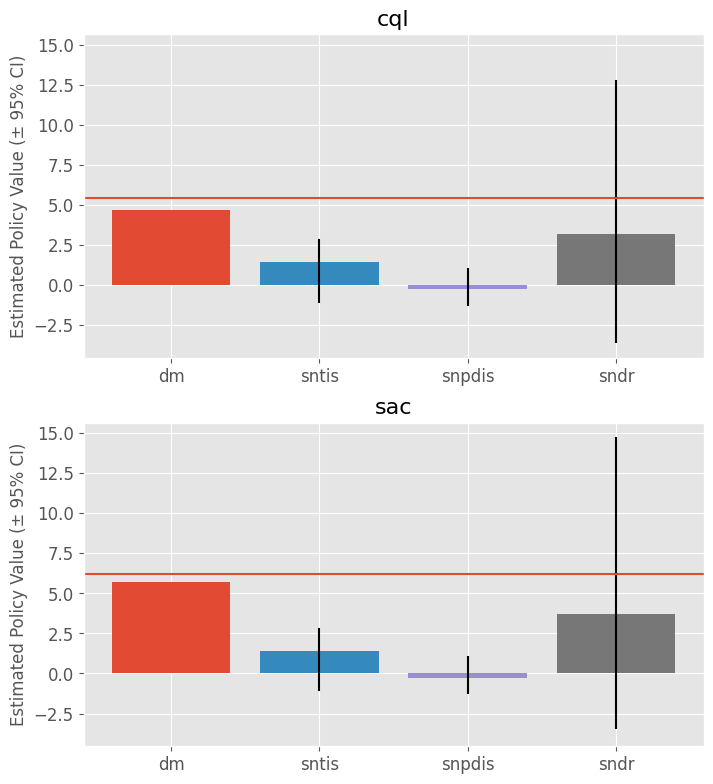

In [48]:
# opeの結果の比較・可視化
# 多くのオフライン指標が方策価値を過小評価しています
# これはオフラインデータが反実的な方策が取りうるデータを十分にカバーできていないことが原因です

ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    random_state=random_state, 
    sharey=True,
)

In [49]:
# OPEの推定の正確さを測るために2乗誤差を利用します
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,sac
dm,5.605949e-01,2.706679e-01
tis,1.817473e+40,1.525981e+40
pdis,7.955874e+40,6.788720e+40
dr,3.171398e+40,1.066296e+41
sntis,1.716838e+01,2.414463e+01
snpdis,3.397777e+01,4.352817e+01
sndr,2.724589e+00,3.662573e+00


OPEのより発展的なトピック(累積分布関数の推定など) やOPSは, [examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb)を参照してください. 

OPEのより発展的な推定量(state(-action) marginal estimators や double reinforcement learningなど)は[examples/quickstart/basic/basic_synthetic_continuous_zoo.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_zoo.ipynb)を参照してください. 

離散的な行動空間に対する例は[examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb)を参照してください.

## 参考文献

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.